In [ ]:
!unzip -q /content/drive/MyDrive/CORD-19-research-challenge.zip -d ~/CORD-19-research-challenge/

In [9]:
import numpy as np 
import pandas as pd 
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import spacy
import wordcloud

# load 
nlp = spacy.load('en_core_web_sm')

# needs to be changed for non-kaggle dirs
root_dir = os.getenv('HOME')
pdf_json_dir = f'{root_dir}/CORD-19-research-challenge/document_parses/pdf_json'
pmc_json_dir = f'{root_dir}/CORD-19-research-challenge/document_parses/pmc_json'
print(pdf_json_dir, '\n', pmc_json_dir)


/content/drive/MyDrive/cord-19-research-challenge/document_parses/pdf_json 
 /content/drive/MyDrive/cord-19-research-challenge/document_parses/pmc_json


## Exploring metadata

Looking at the head of metadata, we can see that there are some papers in `pdf_json` that are also in `pmc_json`. 

In [7]:
metadata = pd.read_csv(f'{root_dir}/cord-19-research-challenge/metadata.csv')
metadata.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
sha_title = metadata[['sha', 'title']].drop_duplicates().shape[0]
title = metadata[['title']].drop_duplicates().shape[0]
sha_title == title

False

We also see below that there are articles that have null titles but also have doi, author, and journal information.  

In [ ]:
metadata.loc[metadata.title.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 37598 to 458836
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          232 non-null    object 
 1   sha               4 non-null      object 
 2   source_x          232 non-null    object 
 3   title             0 non-null      object 
 4   doi               232 non-null    object 
 5   pmcid             6 non-null      object 
 6   pubmed_id         231 non-null    object 
 7   license           232 non-null    object 
 8   abstract          43 non-null     object 
 9   publish_time      232 non-null    object 
 10  authors           222 non-null    object 
 11  journal           232 non-null    object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  0 non-null      object 
 14  arxiv_id          0 non-null      object 
 15  pdf_json_files    4 non-null      object 
 16  pmc_json_files    1 non-null      obj

`pdf_json` and `pmc_json` files have many nulls. Abstacts are also seen to contan numerous nulls.

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476776 entries, 0 to 476775
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          476776 non-null  object 
 1   sha               157554 non-null  object 
 2   source_x          476776 non-null  object 
 3   title             476544 non-null  object 
 4   doi               262674 non-null  object 
 5   pmcid             166958 non-null  object 
 6   pubmed_id         229761 non-null  object 
 7   license           476776 non-null  object 
 8   abstract          344732 non-null  object 
 9   publish_time      476557 non-null  object 
 10  authors           463300 non-null  object 
 11  journal           445028 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  196150 non-null  object 
 14  arxiv_id          6269 non-null    object 
 15  pdf_json_files    157554 non-null  object 
 16  pmc_json_files    12

In [ ]:
def lower_case_lemmas(doc):
    for token in doc :
        token.lemma_ = token.lemma_.lower()
    return doc

nlp.add_pipe(lower_case_lemmas, name = 'lower_case_lemmas', after = 'tagger') 

def get_tokens(docs, unlist = True):
    docs_token_list = []
    for _doc in tqdm(nlp.pipe(docs, disable = ['tagger', 'parser'])):
        tokens = [token.lemma_ for token in _doc if not token.is_stop | token.is_space | token.is_punct]
        docs_token_list.append(tokens)
    
    if unlist:
        # unlist the docs token list
        docs_token_list_ = [tok for tokens in docs_token_list for tok in tokens]
        return docs_token_list_
    else:
        return docs_token_list

def plot_top_n_words(docs_token_list, top_n = 10, figsize = (10, 8), return_counter = False):
    word_freq = Counter(docs_token_list)
    most_freq_words = word_freq.most_common(top_n)
    most_freq_words_df = pd.DataFrame(most_freq_words, columns = ['word', 'count']) 
    fig, ax = plt.subplots(1, figsize = figsize)
    ax.set_title(f'Top {top_n} most frequent words in title')
    most_freq_words_df.plot.barh('word', 'count', ax = ax)
    
    if return_counter:
        return word_freq
    
    plt.show()
    
    

### running the NLP pipeline on the whole set of titles

We try and investigate the whole set of titles and see if there are some things that we should take into account.

In [ ]:
all_titles = metadata.title
all_titles = all_titles.loc[~all_titles.isnull()]
docs_token_list_all = get_tokens(all_titles)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In this simple enumeration of word frequencies, we can see that there are some words that are clearly not english such as *la* and *de*.

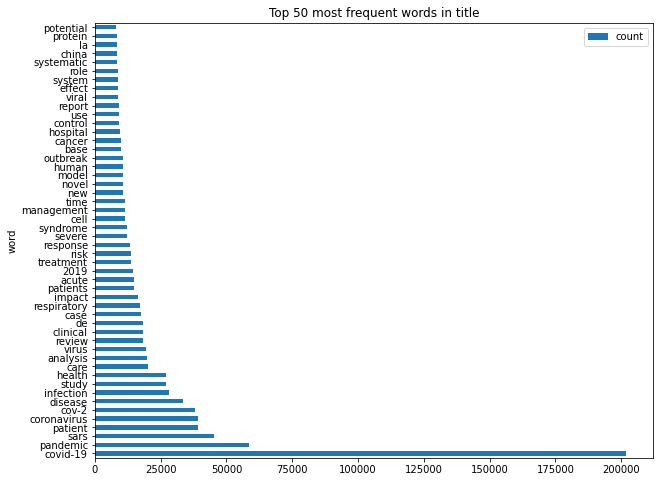

In [ ]:
counter_all = plot_top_n_words(docs_token_list_all, top_n = 50, return_counter = True)

Shown below is a word cloud for the most frequent words in the corpus of article titles.

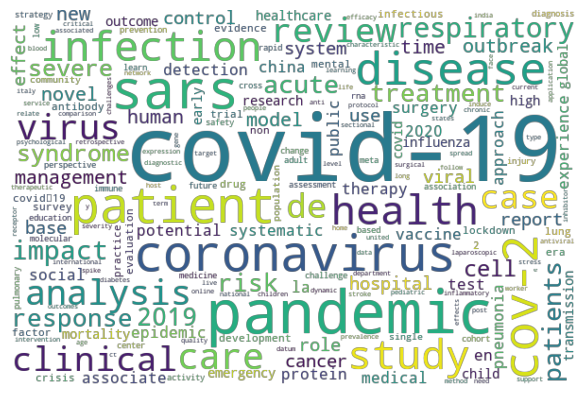

In [ ]:
mpl.rcParams['figure.dpi'] = 100
wc_obj = wordcloud.WordCloud(background_color = None, mode = 'RGBA', width = 600, height = 400)
wc = wc_obj.generate_from_frequencies(counter_all)
fig = plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Identifying languages from title

From the titles, we can further reduce the corpus by removing articles that are not in English. We use the `langid.py` module to identify the primary language of an article.  

In [ ]:
from collections import Counter

In [ ]:
import sys
sys.path.append('langid.py/')
# for google colab
sys.path.append('/content/drive/MyDrive/computing/cord-19-topic-modeling/langid.py/')
import langid
import math

langs = []
for title in tqdm(metadata.title.tolist()):       
    if isinstance(title ,str):
        lang, _ = langid.classify(title)
    else:
        lang = 'unknown'
    langs.append(lang)
metadata['langs'] = langs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
bool_ = np.logical_and(~metadata.pdf_json_files.isna(),
metadata.langs == 'en')
metadata.loc[bool_, ['title']].drop_duplicates()

,title
0,Clinical features of culture-proven Mycoplasma...
1,Nitric oxide: a pro-inflammatory mediator in l...
2,Surfactant protein-D and pulmonary host defense
3,Role of endothelin-1 in lung disease
4,Gene expression in epithelial cells in respons...
...,...
476770,Returning to Play after Prolonged Training Res...
476771,Common determinants of severe Covid-19 infecti...
476772,"Cultural complications: Why, how, and lessons ..."
476773,Detecting the Emergent or Re-Emergent COVID-19...


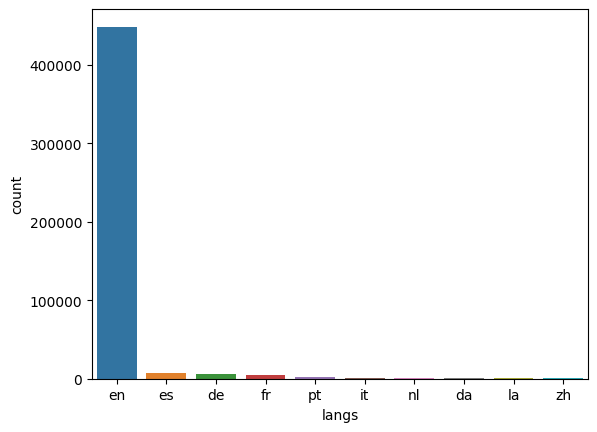

In [ ]:
mpl.rc_file_defaults()
toplangs = metadata.groupby('langs').size().reset_index(name='count') \
    .sort_values(by = 'count', ascending=False).iloc[:10]
sns.barplot(x = 'langs', y = 'count', data = toplangs)

## Exploring a single document

Try opening one file

In [10]:
docs = os.listdir(pdf_json_dir)
doc1 = f'{pdf_json_dir}/{docs[0]}'

with open(doc1) as f:
    doc = json.load(f)

OSError: ignored

In [ ]:
keys_list = list(doc.keys())

for k in keys_list:
    print(k, type(doc[k]))

paper_id <class 'str'>
metadata <class 'dict'>
abstract <class 'list'>
body_text <class 'list'>
bib_entries <class 'dict'>
ref_entries <class 'dict'>
back_matter <class 'list'>


Investigate body text

In [ ]:
for i in doc['body_text']:
    print(type(i), i.keys())
    print(i['section'], '\nlength of text:', len(i['text']), '\n', i['text'], '\n\n')
    

<class 'dict'> dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])
 
length of text: 2322 
 . Echocardiographic evaluation of the effects of human adipose-derived mesenchymal stem cells on cardiac function in adiponectin knockout mice. Data are mean±SEM. Human adipose tissue-derived MSCs (hMSCs) were injected intravenously into the transverse aortic constriction (TAC) model in AKO and WT mice. hMSCs were injected at concentration of 5.0x10 5 cells/body via the tail vein. Injections were repeated six times at 2-3 day intervals within a period of 2 weeks. Echocardiography was performed at day14. Table S3 . Echocardiographic evaluation of T-cadherin knockdown on the effect of human adipose-derived mesenchymal stem cells on cardiac function in wild-type mice. Data are mean±SEM. Human adipose tissue-derived MSCs (hMSCs) were transfected with control or T-cad RNAi and injected at a concentration of 5.0x10 5 cells/body via the tail vein the day after transfection. The injection was repe

get body text total length for `pdf_json`

In [ ]:
def get_body_text(path_to_doc):
    with open(path_to_doc) as f:
        js = json.load(f)
    
    return js['body_text']

In [ ]:
def get_total_lengths(dir, total_num_docs = None):
    # get total list of docs
    docs = os.listdir(dir)
    
    doc_lengths = []
    for i, doc in tqdm(enumerate(docs)):
        # get full directory of json file
        if total_num_docs is None:
            pass
        else:
            if i >= total_num_docs:
                return doc_lengths

        full_path = f'{dir}/{doc}'
        with open(full_path) as f:
            js = json.load(f)
            doc_len = 0
            for t in js['body_text']:
                doc_len += len(t['text'])
            doc_lengths.append(doc_len)

    return doc_lengths

lengths_pdf = get_total_lengths(pdf_json_dir)
                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
lengths_pmc = get_total_lengths(pmc_json_dir)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


PDF lengths
 count    1.675910e+05
mean     2.463415e+04
std      4.589846e+04
min      1.000000e+00
25%      9.494500e+03
50%      1.876400e+04
75%      2.987000e+04
max      6.009611e+06
dtype: float64 

PMC lengths
 count    1.264800e+05
mean     2.253615e+04
std      3.016263e+04
min      1.000000e+00
25%      9.440750e+03
50%      1.874800e+04
75%      2.925800e+04
max      4.091568e+06
dtype: float64


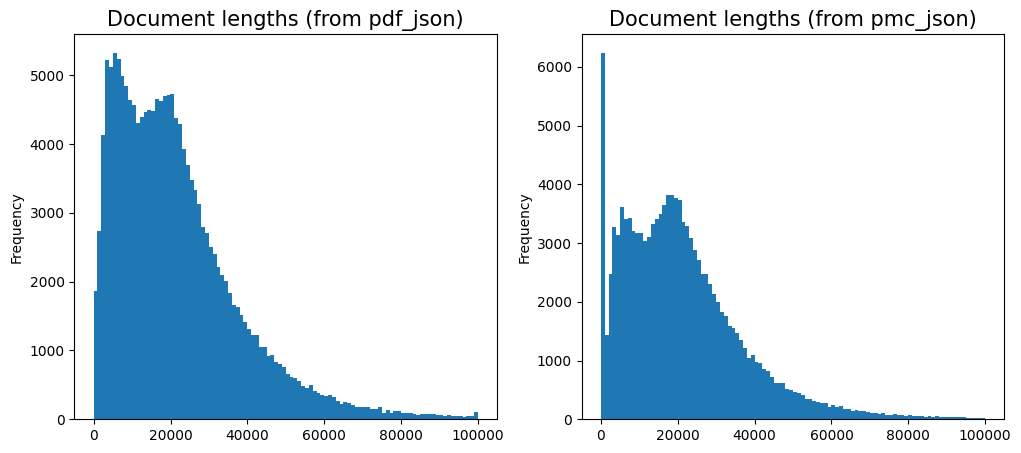

In [ ]:
lengths_pdf_s = pd.Series(lengths_pdf)
lengths_pmc_s = pd.Series(lengths_pmc)
print('PDF lengths\n', lengths_pdf_s.describe(), '\n')
print('PMC lengths\n', lengths_pmc_s.describe())
fig, ax = plt.subplots(1,2, figsize = (12,5))

# remove "outliers" using 1.5 * IQR from 75th quartile
outlier_boundary = 1.5 * scipy.stats.iqr(np.array(lengths_pdf))
p75 = np.quantile(lengths_pdf, 0.75)

lengths_pdf_s_new = lengths_pdf_s.loc[lengths_pdf_s <= 1e5]
lengths_pmc_s_new = lengths_pmc_s.loc[lengths_pmc_s <= 1e5]

lengths_pdf_s_new.plot(kind = 'hist', bins= 100, ax = ax[0])
lengths_pmc_s_new.plot(kind = 'hist', bins = 100, ax = ax[1])
ax[0].set_title('Document lengths (from pdf_json)', size = 15)
ax[1].set_title('Document lengths (from pmc_json)', size = 15)
plt.show()

We now investigate documents that are greater than 100,000 characters. Most documents are a group of abstracts or vignettes for a congress/conference. Below is the word cloud for the titles of these documents. We can see that major words are related to compendiums of studies, as indicated by the words *abstracts*, *Meeting*, *Sessions*.

In [ ]:
doc_idx = lengths_pdf_s.loc[lengths_pdf_s > 1e5].index
sha_list = [docs[i].replace('.json', '') for i in doc_idx]
titles = metadata.loc[metadata.sha.isin(sha_list)][['title', 'sha']].title
docs_token_grt_limit = get_tokens(titles)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


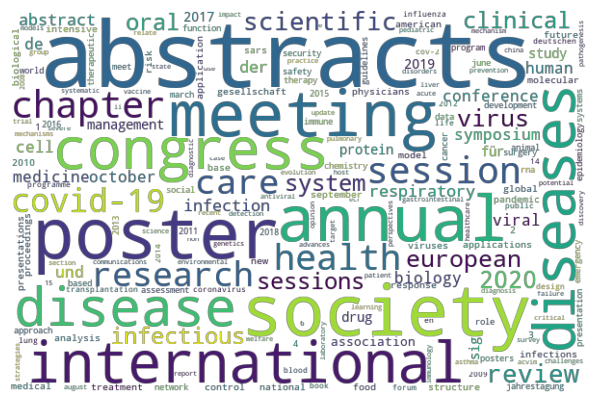

In [ ]:
wc = wc_obj.generate_from_frequencies(Counter(docs_token_grt_limit))
fig = plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Get final documents

We get the final set of documents that we will be using (based on `pdf_json`) by removing articles that are not in English, and have character lengths that are greater than 100,000. 

In [ ]:
doc_idx = lengths_pdf_s.loc[lengths_pdf_s <= 1e5].index
sha_list2 = [docs[i].replace('.json', '') for i in doc_idx]
bool_ = np.logical_and(metadata.sha.isin(sha_list2), metadata.langs == 'en')
final_sha_titles = metadata.loc[bool_][['title', 'sha']]

In [ ]:
final_sha_titles.shape

(140163, 2)

We then check the word cloud again and bar plots and see the dominant terms in the set of documents 

In [ ]:
docs_token_fnl = get_tokens(final_sha_titles.title)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


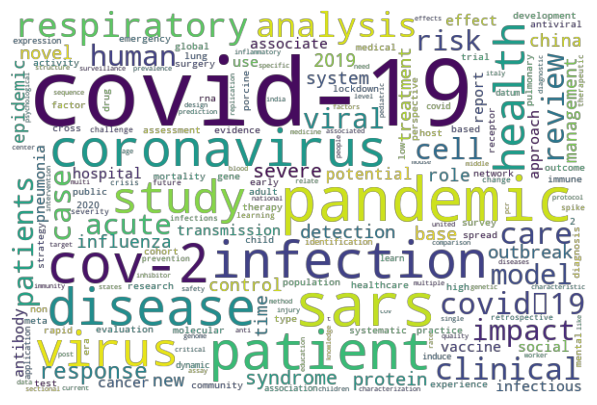

In [ ]:
wc = wc_obj.generate_from_frequencies(Counter(docs_token_fnl))
fig = plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

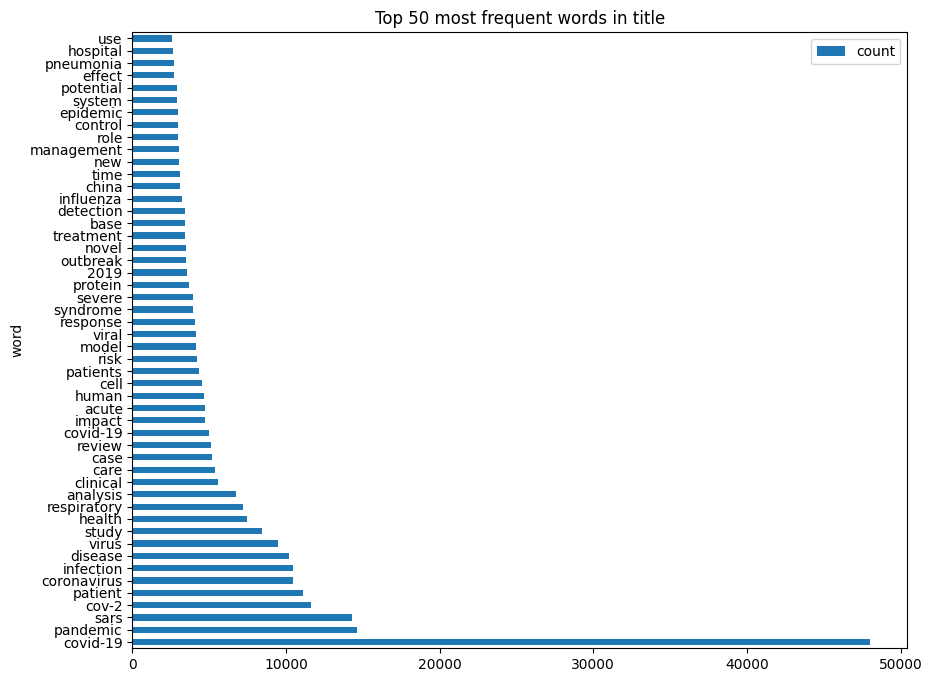

In [ ]:
counter_token_fnl = plot_top_n_words(docs_token_fnl, top_n = 50, return_counter = True)

In [ ]:
final_sha_titles['sha'].to_pickle('/content/drive/MyDrive/final_document_list.pkl')